In [1]:
import os
import subprocess

import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Compose
from torchvision import datasets

from nuy_v2_loader import NYUV2Dataset

In [ ]:
if not os.path.exists('datasets/diode.tar.gz'):
    subprocess.run(
        ['curl', '-L', '-o', 'datasets/diode.tar.gz', 'http://diode-dataset.s3.amazonaws.com/train.tar.gz'],
        check=True
    )

In [ ]:
if not os.path.exists('datasets/nyu_depth_v2'):
    import tensorflow_datasets as tfds
    tfds.load(
        'nyu_depth_v2',
        data_dir='datasets'
    )

In [2]:
NYUV2Dataset("ds", ToTensor(), ToTensor(), 'train', download=True)

Finished loading dataset


In [68]:
import h5py
from PIL import Image
import numpy as np

f = h5py.File("ds/nyudepthv2/train/basement_0001a/00001.h5", "r")

img = f["depth"]
img = np.stack([(img[channel]) for channel in range(len(img))], axis=0)
# img = np.transpose(img, axes=[1, 2, 0])

np.max(img)

6.6245503

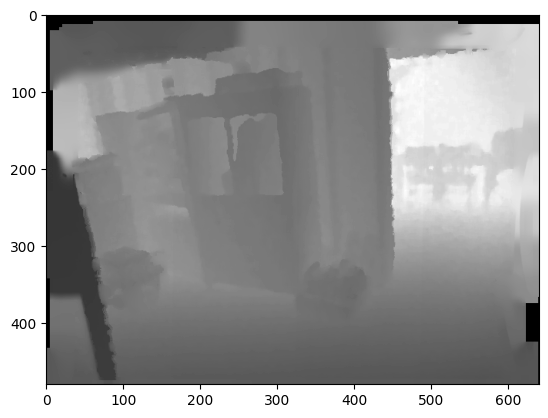

In [69]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap='gray')